### Procedure for making OHLC candels

In [79]:
# Python 3.8.2 kernel
import pandas as pd
import numpy as np
import os
import json
import pandas_datareader.data as web   # my local kernel Python 3.10.7 
import matplotlib.pyplot as plt  # unavailable?  do: 1. pip uninstall matplotlib # 2. python3 -m pip install matplotlib
%matplotlib inline
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import datetime
import io
import statsmodels.api as sm                             ####   reference print(sm.datasets.macrodata.NOTE) 
pd.set_option('display.max_columns', None)

### Convert Tick data to proper DF format, name columns, map categorical column, delete unneeded columns
- to be called TickPrep 

In [38]:
    ## TickPrep .csv file for conversion to candles from original TICK dataset
    
d = r"C:\BidAskRepo\NQ 12-22 Globex_2022_10_27.csv"
nq =  pd.read_csv(d)
col = ['DateTime', 'Vol', 'BidAsk', 'Bid', 'Ask', 'Close']
nq.columns = col
mapping = {'AtBid': -1, 'AtAsk': 1, 'BelowBid': -2, 'AboveAsk': 2, 'BetweenBidAsk':0 }   # remap categorical ---->  ints
nq = nq.replace({'BidAsk': mapping}) 
nq.head()
del nq['Bid']
del nq['Ask']

nq.index = nq.DateTime
nq.index = pd.to_datetime(nq.index)
type(nq.index)
del nq['DateTime'] 

nq['Date'] = nq.index
nq.rename(columns={'Date':'Date'}, inplace=True)
nq.head()
# nq.dtypes
# nq.shape # (692637, 4)
# nq.to_csv('2022-10-27_NQ_preped.csv')

,Vol,BidAsk,Price,Date
DateTime,,,,
2022-10-27 00:00:01,1,-1,11498.25,2022-10-27 00:00:01
2022-10-27 00:00:01,1,-1,11498.25,2022-10-27 00:00:01
2022-10-27 00:00:01,2,-1,11498.25,2022-10-27 00:00:01
2022-10-27 00:00:01,1,-1,11498.25,2022-10-27 00:00:01
2022-10-27 00:00:01,1,-1,11498.25,2022-10-27 00:00:01


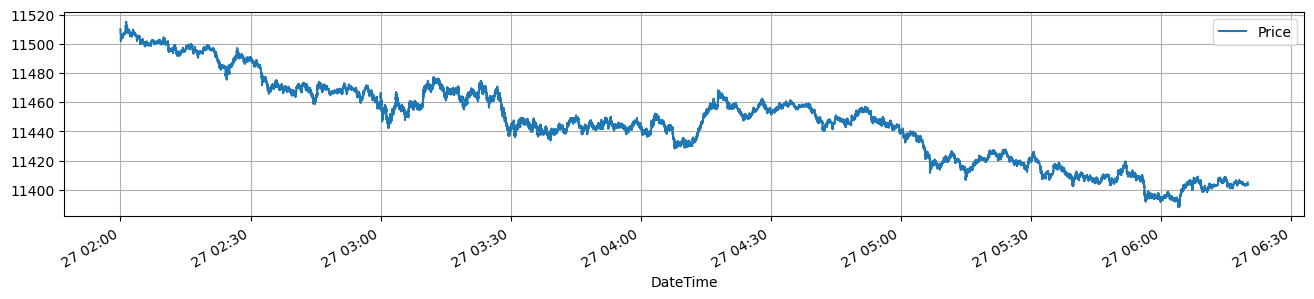

In [42]:
# check visually tick df
nq['2022-10-27 02:00:00': '2022-10-27 06:20:00'].plot(y = ['Price'] , figsize=(16,3))  # LR sample
plt.grid()

### General Functions for Resampling varioes interval frequences

In [43]:
## procedural functions for OHLC candles
from functools import reduce

def merge_manyDF(df1, df2):
    data_frames = [df1, df2]
    df_merged = reduce(lambda  left, right: pd.merge(left, right, on='Date', how='outer'), data_frames)
    return df_merged

def resampling_10min(col1, name1, on_col, on_name):
    '''make resampled df from columns for 1 min'''  # .fillna(0)
    df = pd.DataFrame({name1: col1, on_name: on_col})
    dfHigh = df.resample('10min', on= on_name).max()             
    dfLow = df.resample('10min', on= on_name).min() 
    dfOpen = df.resample('10min', on= on_name).first() 
    dfClose = df.resample('10min', on= on_name).last() 
    
    res_df1 = merge_manyDF(dfOpen, dfHigh)
    res_df2 = merge_manyDF(dfLow, dfClose)
    final = merge_manyDF(res_df1, res_df2)
    return final

def resampling_2Sec(col1, name1, on_col, on_name):
    '''make resampled df from columns for 1 sec'''  # .fillna(0)
    df = pd.DataFrame({name1: col1, on_name: on_col})
    dfHigh = df.resample('2S', on= on_name).max()             
    dfLow = df.resample('2S', on= on_name).min() 
    dfOpen = df.resample('2S', on= on_name).first() 
    dfClose = df.resample('2S', on= on_name).last() 
    
    res_df1 = merge_manyDF(dfOpen, dfHigh)
    res_df2 = merge_manyDF(dfLow, dfClose)
    final = merge_manyDF(res_df1, res_df2)
    return final

def resampling_10Sec(col1, name1, on_col, on_name):
    '''make resampled df from columns for 1 sec'''  # .fillna(0)
    df = pd.DataFrame({name1: col1, on_name: on_col})
    dfHigh = df.resample('10S', on= on_name).max()             
    dfLow = df.resample('10S', on= on_name).min() 
    dfOpen = df.resample('10S', on= on_name).first() 
    dfClose = df.resample('10S', on= on_name).last() 
    
    res_df1 = merge_manyDF(dfOpen, dfHigh)
    res_df2 = merge_manyDF(dfLow, dfClose)
    final = merge_manyDF(res_df1, res_df2)
    return final

def resampling_3Min(col1, name1, on_col, on_name):
    '''make resampled df from columns for 1 sec'''  # .fillna(0)
    df = pd.DataFrame({name1: col1, on_name: on_col})
    dfHigh = df.resample('3T', on= on_name).max()             
    dfLow = df.resample('3T', on= on_name).min() 
    dfOpen = df.resample('3T', on= on_name).first() 
    dfClose = df.resample('3T', on= on_name).last() 
    
    res_df1 = merge_manyDF(dfOpen, dfHigh)
    res_df2 = merge_manyDF(dfLow, dfClose)
    final = merge_manyDF(res_df1, res_df2)
    return final

def resampling_2Sec_BidAsk(col1, name1, on_col, on_name):
    '''make resampled df from columns for 1 sec'''  # .fillna(0)
    df = pd.DataFrame({name1: col1, on_name: on_col})
    dfHigh = df.resample('2S', on= on_name).sum()             
    dfLow = df.resample('2S', on= on_name).sum() 
    dfOpen = df.resample('2S', on= on_name).sum() 
    dfClose = df.resample('2S', on= on_name).sum() 
    
    res_df1 = merge_manyDF(dfOpen, dfHigh)
    res_df2 = merge_manyDF(dfLow, dfClose)
    final = merge_manyDF(res_df1, res_df2)
    return final

def resampling_1MinBidAsk(col1, name1, on_col, on_name):
    '''make resampled df from columns for 1 sec'''  # .fillna(0)
    df = pd.DataFrame({name1: col1, on_name: on_col})
    dfHigh = df.resample('1T', on= on_name).sum()             
    dfLow = df.resample('1T', on= on_name).sum() 
    dfOpen = df.resample('1T', on= on_name).sum() 
    dfClose = df.resample('1T', on= on_name).sum() 
    
    res_df1 = merge_manyDF(dfOpen, dfHigh)
    res_df2 = merge_manyDF(dfLow, dfClose)
    final = merge_manyDF(res_df1, res_df2)
    return final

def resampling_3MinBidAsk(col1, name1, on_col, on_name):
    '''make resampled df from columns for 1 sec'''  # .fillna(0)
    df = pd.DataFrame({name1: col1, on_name: on_col})
    dfHigh = df.resample('3T', on= on_name).sum()             
    dfLow = df.resample('3T', on= on_name).sum() 
    dfOpen = df.resample('3T', on= on_name).sum() 
    dfClose = df.resample('3T', on= on_name).sum() 
    
    res_df1 = merge_manyDF(dfOpen, dfHigh)
    res_df2 = merge_manyDF(dfLow, dfClose)
    final = merge_manyDF(res_df1, res_df2)
    return final

def resampling_1min(col1, name1, on_col, on_name):
    '''make resampled df from columns for 1 min'''  # .fillna(0)
    df = pd.DataFrame({name1: col1, on_name: on_col})
    dfHigh = df.resample('1min', on= on_name).max()             
    dfLow = df.resample('1min', on= on_name).min() 
    dfOpen = df.resample('1min', on= on_name).first() 
    dfClose = df.resample('1min', on= on_name).last() 
    
    res_df1 = merge_manyDF(dfOpen, dfHigh)
    res_df2 = merge_manyDF(dfLow, dfClose)
    final = merge_manyDF(res_df1, res_df2)
    return final

def merge_DFs(d1, d2, d3):
    d = pd.DataFrame()
    d = pd.merge(d1, d2, on='Date')
    d = pd.merge(d, d3, on='Date')
    return d

### Procedure for 1 min OHLC candles from TickPrep dataframe

In [88]:
nqPrice = resampling_1min(nq['Price'], 'Price', nq.Date, 'Date')
mapping2 = {nqPrice.columns[0]: 'Open', nqPrice.columns[1]: 'High', nqPrice.columns[2]: 'Low', nqPrice.columns[3]: 'Close'}
nqPrice = nqPrice.rename(columns= mapping2)
nqPrice.sample(5)
nqPrice.shape #(1440, 4)

nqVol = resampling_1MinBidAsk(nq['Vol'], 'Vol', nq.Date, 'Date')
mapping2 = {nqVol.columns[3]: 'Vol'}
nqVol = nqVol.rename(columns= mapping2)
del nqVol['Vol_x_x']
del nqVol['Vol_y_x']
del nqVol['Vol_x_y']
nqVol.head()
nqVol.shape #(1440, 1)

nqBidAsk = resampling_1MinBidAsk(nq['BidAsk'], 'BidAsk', nq.Date, 'Date')
mapping2 = {nqBidAsk.columns[3]: 'BidAsk'}
nqBidAsk = nqBidAsk.rename(columns= mapping2)
del nqBidAsk['BidAsk_x_x']
del nqBidAsk['BidAsk_y_x']
del nqBidAsk['BidAsk_x_y']
nqBidAsk.head()
nqBidAsk.shape #(1440, 1)

nq_1min = merge_DFs(nqPrice, nqVol, nqBidAsk)
nq_1min.dropna(inplace=True)
nq_1min.shape   #   (1440, 6) ;   after droping NaN: (1380, 6)
nq_1min.sample(2)
# nq_1min.to_csv('2022-10-27_NQ_1m.csv')   # save 1 min df

,Open,High,Low,Close,Vol,BidAsk,trend
Date,,,,,,,
2022-10-27 10:28:00,11422.5,11430.25,11415.0,11417.25,943,-170,11420.666543
2022-10-27 10:56:00,11371.0,11371.50,11357.0,11364.50,1044,-105,11354.715862


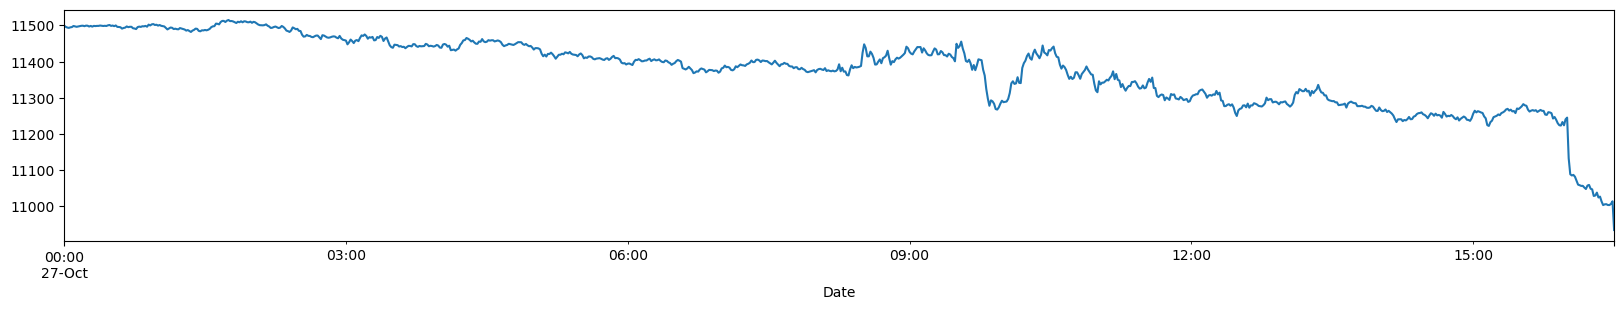

In [89]:
nq_1min['Close']['2022-10-27 00:00': '2022-10-27 16:30:00'].plot(figsize=(20,3) )

### Procedure for 2 sec OHLC candles from TickPrep dataframe

In [115]:
nqPrice_2sec = resampling_2Sec(nq['Price'], 'Price', nq.Date, 'Date')
mapping2S = {nqPrice_2sec.columns[0]: 'Open', nqPrice_2sec.columns[1]: 'High', nqPrice_2sec.columns[2]: 'Low', nqPrice_2sec.columns[3]: 'Close'}
nqPrice_2sec = nqPrice_2sec.rename(columns= mapping2S)
nqPrice_2sec.head(20)
nqPrice_2sec.shape  #  (43199, 4) -----------

nqVol2sec = resampling_2Sec_BidAsk(nq['Vol'], 'Vol', nq.Date, 'Date')
mappingV = {nqVol2sec.columns[0]: 'Vol'}
nqVol2sec = nqVol2sec.rename(columns= mappingV)
del nqVol2sec['Vol_y_x']
del nqVol2sec['Vol_x_y']
del nqVol2sec['Vol_y_y']
nqVol2sec.sample(5)
nqVol2sec.shape #  (43199, 1)   

nqBidAsk2Sec = resampling_2Sec_BidAsk(nq['BidAsk'], 'BidAsk', nq.Date, 'Date')
mappingBA2s = {nqBidAsk2Sec.columns[1]: 'BidAsk'}
nqBidAsk2Sec = nqBidAsk2Sec.rename(columns= mappingBA2s)
del nqBidAsk2Sec['BidAsk_x_x']
del nqBidAsk2Sec['BidAsk_x_y']
del nqBidAsk2Sec['BidAsk_y_y']
nqBidAsk2Sec.tail(20)
nqBidAsk2Sec.shape     # (43199, 1)

nq_2Sec = merge_DFs(nqPrice_2sec, nqVol2sec, nqBidAsk2Sec)
nq_2Sec.shape   # (43199, 6)   
nq_2Sec.dropna(inplace=True) #   after droping NaN's it is: (35080, 6)
nq_2Sec.sample(3)
# nq_2Sec.to_csv('2022-10-27_NQ_2sec.csv')    # save 2 seconds resampled set

### Procedure for 3 min OHLC candles from TickPrep dataframe

In [148]:
# nqPrice_3min = resampling_3Min(nq['Price'], 'Price', nq.Date, 'Date')
# mapping3M = {nqPrice_3min.columns[0]: 'Open', nqPrice_3min.columns[1]: 'High', nqPrice_3min.columns[2]: 'Low', nqPrice_3min.columns[3]: 'Close'}
# nqPrice_3min = nqPrice_3min.rename(columns= mapping3M)
# nqPrice_3min.head()
# nqPrice_3min.shape  #   3 min = (480, 4)

# nqVol3 = resampling_3Min(nq['Vol'], 'Vol', nq.Date, 'Date')
# mapping3 = {nqVol3.columns[1]: 'Vol'}
# nqVol3 = nqVol3.rename(columns= mapping3)
# del nqVol3['Vol_x_x']
# del nqVol3['Vol_y_y']
# del nqVol3['Vol_x_y']
# nqVol3.sample(5)
# nqVol3.shape # (480, 4)

# nqBidAsk3 = resampling_3MinBidAsk(nq['BidAsk'], 'BidAsk', nq.Date, 'Date')
# mappingBA = {nqBidAsk3.columns[1]: 'BidAsk'}
# nqBidAsk3 = nqBidAsk3.rename(columns= mappingBA)
# del nqBidAsk3['BidAsk_x_x']
# del nqBidAsk3['BidAsk_x_y']
# del nqBidAsk3['BidAsk_y_y']
# nqBidAsk3.sample(20)
# nqBidAsk3.shape     # (480, 1)

# nq_3min = merge_DFs(nqBidAsk3, nqVol3, nqPrice_3min)
# nq_3min.shape                                # (480, 6)
# nq_3min.dropna(inplace=True)
nq_3min.shape         #  after droping NaN's   (460, 6)
# nq_3min.head()
nq_3min.sample(5)
# nq_3min.to_csv('2022-10-27_NQ_3m.csv')    # save 3 min OHLC set

### Visualize set with OHLC candles

In [152]:
fig = go.Figure(data= go.Ohlc(x= nq_1min.index, open= nq_1min['Open'], high= nq_1min['High'],  
                low= nq_1min['Low'], close= nq_1min['Close'], text= hovertext, hoverinfo= 'text'))
fig.show()

In [149]:
import plotly.graph_objects as go
# hovertext=[]
# for i in range(len(nq_3min['Open'])):
#     hovertext.append('Open: '+str(nq_3min['Open'][i])+'<br>Close: '+ str(nq_3min['Close'][i]))
fig = go.Figure(data=go.Ohlc(x=nq_3min.index, open=nq_3min['Open'], high=nq_3min['High'],  
                low=nq_3min['Low'], close=nq_3min['Close'], text= hovertext, hoverinfo='text'))
fig.show()

###  Load 4 LR's

In [ ]:
lr1 = pd.read_csv()